In [14]:
import data_generator as dg
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from sin_dataset import SinDataset

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Hyperparameters

In [15]:
input_size = 256
hidden_channels = 3
dataset_size = 8196*8
batch_size = 256
num_classes = 3
epochs = 10
start_learning_rate = 0.1

Neural network strucure and models

In [16]:
class SinModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv1d(1, hidden_channels,
             kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, 1,
             kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(input_size, num_classes))            
        
    def forward(self, xb):
        out = self.network(xb)        
        return out
    
    def training_step(self, batch):
        data, labels = batch 
        out = self(data)                  # Generate predictions
        loss_fn = nn.MSELoss()
        return loss_fn(out,labels)
    
    def validation_step(self, batch):
        data, labels = batch 
        out = self(data)            
        loss_fn = nn.MSELoss()        # Generate predictions
        loss = loss_fn(out,labels)              
        acc = accuracy(out,labels)         
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses    

        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc, _ = torch.max(torch.stack(batch_acc), dim = 0)   # Combine acc        
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.tolist()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
        print("Max differences:")
        print("    amplitude: {:.4f}, frequency: {:.4f},phase: {:.4f},".format(result['val_acc'][0],
         result['val_acc'][1],
         result['val_acc'][2],
         ))

Function to output max-difference in Amplitude, Frequency, and Phase

In [17]:
def accuracy(output,labels):
    diff = torch.abs(output - labels)  
    maxes, indexes = torch.max(diff, dim = 0)  
    return maxes

Some functions to run training of NN

In [18]:
def evaluate(model, val_set):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_set]
    return model.validation_epoch_end(outputs)

def fit(epochs, start_learning_rate, model, train_set, val_set, opt_func=torch.optim.Adam):
    """Train the model using gradient descent"""
    losses = []
    history = []
    lr = start_learning_rate    
    for epoch in range(epochs):
        # Training Phase 
        optimizer = opt_func(model.parameters(), lr)
        for batch in train_set:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        # Validation phase
        result = evaluate(model, val_set)
        model.epoch_end(epoch, result)
        history.append(result)
        lr = lr * 0.5;

    return losses, history

Generate data

In [19]:
train_set = SinDataset(size = dataset_size,
 samples = input_size,
 batch_size = batch_size)
val_set = SinDataset(size = dataset_size,
 samples = input_size,
 batch_size = batch_size)

Plot first two batches of train data and labels

torch.Size([256, 1, 256])


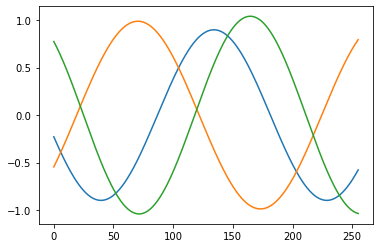

In [20]:
for data,labels in train_set:    
    print(data.shape)
    plt.plot(data[0,0,:])
    plt.plot(data[1,0,:])
    plt.plot(data[2,0,:])
    plt.show()
    break

Run network training

Epoch [0], val_loss: 2.8152
Max differences:
    amplitude: 0.2062, frequency: 5.1876,phase: 0.5037,
Epoch [1], val_loss: 2.9359
Max differences:
    amplitude: 0.2137, frequency: 5.6049,phase: 0.5581,
Epoch [2], val_loss: 2.9598
Max differences:
    amplitude: 0.2059, frequency: 5.6610,phase: 0.5618,
Epoch [3], val_loss: 2.9279
Max differences:
    amplitude: 0.2160, frequency: 5.5862,phase: 0.5414,
Epoch [4], val_loss: 2.8743
Max differences:
    amplitude: 0.2060, frequency: 5.4286,phase: 0.5690,
Epoch [5], val_loss: 2.8164
Max differences:
    amplitude: 0.2025, frequency: 5.1177,phase: 0.5118,
Epoch [6], val_loss: 2.8139
Max differences:
    amplitude: 0.2082, frequency: 5.0688,phase: 0.5386,
Epoch [7], val_loss: 2.8181
Max differences:
    amplitude: 0.2064, frequency: 5.1385,phase: 0.5054,
Epoch [8], val_loss: 2.8180
Max differences:
    amplitude: 0.2060, frequency: 5.1376,phase: 0.5013,
Epoch [9], val_loss: 2.8129
Max differences:
    amplitude: 0.2042, frequency: 5.0574,phase

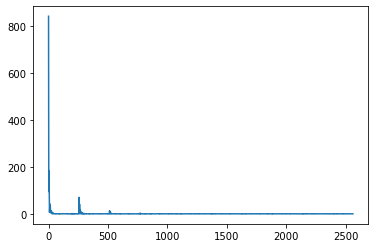

In [22]:
model = SinModel()
losses, history = fit(epochs,
 start_learning_rate,
  model, train_set, val_set)
plt.plot(losses)
plt.show()